In [37]:
from abc import ABC, abstractmethod
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import json

class TableDetector(ABC):
    def __init__(self, result_dir, test_run=False, fraction=0.1):
        self.result_dir = result_dir

        self.df_truth = pd.read_csv("../benchmark_truth/table_detection.csv")
        if test_run:
            self.df_truth = self.df_truth.sample(frac=fraction, random_state=42)
        
        self.df = self.df_truth.copy()
        self.df['score'] = pd.NA
        
        self.total_pages = self.df.shape[0]
        self.benchmark_results = {'metrics': pd.DataFrame(columns=['threshold', 'precision', 'recall', 'recall_target', 'F1']), 'runtime': pd.NA}

    def get_benchmark_results(self):
        return self.benchmark_results
    
    def plot_benchmark(self):
        df = self.benchmark_results['metrics']

        # Plot the metrics over the threshold
        plt.figure(figsize=(10, 6))
        plt.plot(df['threshold'], df['F1'], label='F1', marker='')
        plt.plot(df['threshold'], df['precision'], label='Precision', marker='')
        plt.plot(df['threshold'], df['recall'], label='Recall', marker='')
        plt.plot(df['threshold'], df['recall_target'], label='Recall Target', marker='')

        # Add labels, title, and legend
        plt.xlabel('Threshold')
        plt.ylabel('Metrics')
        plt.title('Metrics vs Threshold')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()

    def save_results(self):
        with open(f"{self.result_dir}.json", "w") as json_file:
            json.dump(
                {key: value.to_json(orient='records') if hasattr(value, 'to_json') else value 
                for key, value in self.benchmark_results.items()}, 
                json_file, 
                indent=4, 
                default=str
            )

    @abstractmethod
    def benchmark(self):
        pass

In [53]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image, ImageDraw, ImageFont
from transformers import pipeline
import numpy as np
from pdf2image import convert_from_path
import warnings

warnings.filterwarnings("ignore")

class TableDetectorAI(TableDetector):
    def __init__(self, result_dir, verbose=False, ocr=False, model_name='yolov12n-doclaynet', thresholds=[x/100.0 for x in range(0,100,1)], **kwargs):
        super().__init__(result_dir, **kwargs)
        self.verbose = verbose
        self.ocr = ocr
        self.model_name = model_name
        self.thresholds = thresholds

        self.__set_environment()

    def __set_environment(self):
        if self.model_name == "microsoft/table-transformer-detection":
            self.pipe = pipeline("object-detection", model="microsoft/table-transformer-detection")
            self.font = ImageFont.truetype(font="/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", size = 20)
            
        elif re.search(r'yolov12[nsml]-doclaynet', self.model_name):
            self.model = YOLO(f"../models/YOLO/{self.model_name}.pt")
            self.table_idx = next((idx for idx, name in self.model.names.items() if name == "Table"), pd.NA)
            
        else:
            raise ValueError(f"Unknown pdfbackend: {self.model_name}")

    def __detect_tables(self, image):
        if self.model_name == "microsoft/table-transformer-detection":
            results = self.pipe(image, threshold=0)

            if self.verbose:    
                # Draw the bounding boxes on the image
                draw = ImageDraw.Draw(image)
                for result in results:
                    box = result['box']
                    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))  # Create a transparent overlay
                    overlay_draw = ImageDraw.Draw(overlay)
                    overlay_draw.rectangle([box['xmin'], box['ymin'], box['xmax'], box['ymax']], width=3, outline=(255, 0, 0, int(result['score']*220+35)))  # Add alpha to the fill color
                    overlay_draw.text((box['xmin']+10, box['ymin']+10), f"score: {result['score']:.2f}", fill=(255, 0, 0, int(result['score']*220+35)), font=self.font)
                    image = Image.alpha_composite(image.convert('RGBA'), overlay)  # Composite the overlay with the original image

                # Show the image with the bounding boxes
                image.show()

            score = max(result['score'] for result in results) if len(results) > 0 else 0            
            return score

        elif re.search(r'yolov12[nsml]-doclaynet', self.model_name):
            pred = self.model(image, verbose=False)

            if self.verbose:
                for r in pred:
                    annotator = Annotator(image)
                        
                    boxes = r.boxes
                    for box in boxes:
                        
                        b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
                        c = box.cls
                        annotator.box_label(b, f'{self.model.names[int(c)]}: {round(float(box.conf),2)}')
                    
                    img = annotator.result()
                    # Convert the numpy array to a PIL Image and display it
                    Image.fromarray(img).show()

            scores = [float(box.conf) for prediction in pred for box in prediction.boxes if int(box.cls) == self.table_idx]
            score = max(scores) if len(scores)>0 else 0            
            return score        

    def __analyze_pages(self):
        counter = 0
        for _, row in self.df.iterrows():
            counter += 1
            print(f'{counter}/{self.total_pages}', end="\r")

            filepath = row['filepath']
            page_num = int(row['page'])

            images = convert_from_path(filepath, first_page=page_num, last_page=page_num)
            if len(images) > 0:
                self.df.loc[_, 'score'] = self.__detect_tables(images[0])

    def __calculate_metrics(self):
        for threshold in self.thresholds:
            x = self.df.copy()
            x['prediction'] = np.where(x['score'] > threshold, 1, 0)

            true_positive = x[(x['table'] == 1) & (x['prediction'] == 1)].shape[0]
            false_positive = x[(x['table'] == 0) & (x['prediction'] == 1)].shape[0]
            # true_negative = x[(x['table'] == 0) & (x['prediction'] == 0)].shape[0]
            false_negative = x[(x['table'] == 1) & (x['prediction'] == 0)].shape[0]

            y = x[x['target'] == 1]

            true_positive_target = y[(y['table'] == 1) & (y['prediction'] == 1)].shape[0]
            false_negative_target = y[(y['table'] == 1) & (y['prediction'] == 0)].shape[0]

            precision = round(true_positive/(true_positive+false_positive),2) if (true_positive+false_positive) > 0 else pd.NA
            recall = round(true_positive/(true_positive+false_negative),2) if (true_positive+false_negative) > 0 else pd.NA
            recall_target = round(true_positive_target/(true_positive_target+false_negative_target),2) if (true_positive_target+false_negative_target) > 0 else pd.NA
            F1 = round(2*precision*recall/(precision+recall),2) if (precision is not pd.NA and recall is not pd.NA and (precision+recall) > 0) else pd.NA

            self.benchmark_results['metrics'] = pd.concat([
                self.benchmark_results['metrics'], 
                pd.DataFrame([{'threshold': threshold, 'precision': precision, 'recall': recall, 'recall_target': recall_target, 'F1': F1}])], 
                ignore_index=True)

        
    def benchmark(self, safe_to_json=True):
        start_time = time.time()        
        
        self.__analyze_pages()
        self.__calculate_metrics()
                
        end_time = time.time()
        runtime = end_time - start_time
        self.benchmark_results['runtime'] = runtime

        if safe_to_json:
            self.save_results()

In [ ]:
yolo12nano = TableDetectorAI(
    result_dir="../benchmark_results/table_detection/yolo12n-doclaynet", 
    model_name='yolov12n-doclaynet',
    test_run=False,
    fraction=0.03,
    verbose=False,
    )

yolo12nano.benchmark()
yolo12nano.plot_benchmark()

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


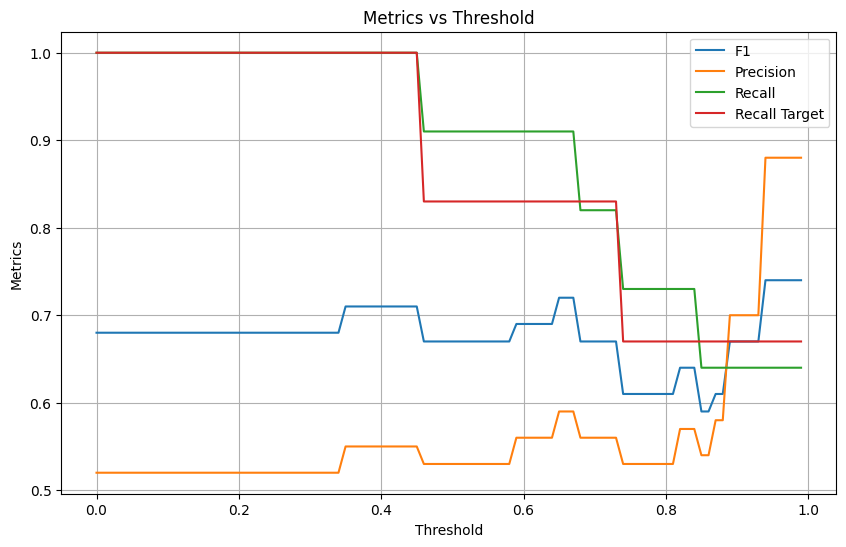

In [ ]:
microsoft_table_detection = TableDetectorAI(
    result_dir="../benchmark_results/table_detection/microsoft-table-transformer-detection", 
    model_name='microsoft/table-transformer-detection',
    test_run=False,
    fraction=0.03,
    verbose=False,
    )

microsoft_table_detection.benchmark()
microsoft_table_detection.plot_benchmark()

In [ ]:
yolo12large = TableDetectorAI(
    result_dir="../benchmark_results/table_detection/yolo12l-doclaynet", 
    model_name='yolov12l-doclaynet',
    test_run=False,
    fraction=0.03,
    verbose=False,
    )

yolo12large.benchmark()
yolo12large.plot_benchmark()